In [ ]:
!pip install -q kaggle

To download dataset from kaggle upload your kaggle.json file below:

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sachinpatel21/az-handwritten-alphabets-in-csv-format

Downloading dataset saved in Gdrive to /content/

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/My\ Drive/az-handwritten-alphabets-in-csv-format.zip /content/
!unzip /content/az-handwritten-alphabets-in-csv-format.zip

Mounted at /content/drive
Archive:  /content/az-handwritten-alphabets-in-csv-format.zip
  inflating: A_Z Handwritten Data.csv  
  inflating: A_Z Handwritten Data/A_Z Handwritten Data.csv  


**Importing Required Libraries**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau

Loading Dataset and Labels

In [3]:
dataset = pd.read_csv("/content/A_Z Handwritten Data.csv")
y=dataset['0']
del dataset['0']

Number of images available per class

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


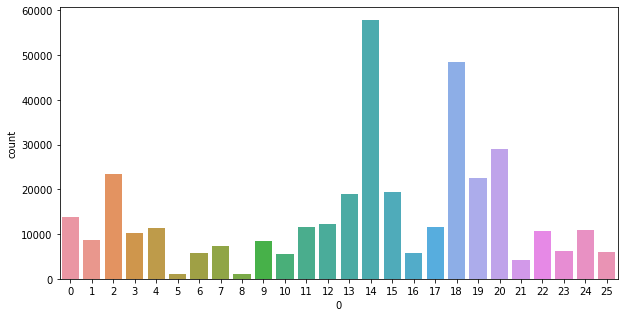

In [4]:
plt.figure(figsize = (10,5))
sns.countplot(y)

There are two ways to balance the dataset using sampling:

* Undersampling — Deleting samples from the majority class.
* Oversampling — Duplicating samples from the minority class

As we have such high number of images, we'll using undersampling instead and cut-off the excess.

The NeadMiss algorithm does Undersampling by looking at the class distribution and randomly eliminating samples from the larger class. When two points belonging to different classes are very close to each other in the distribution, this algorithm eliminates the datapoint of the larger class thereby trying to balance the distribution. 

In [ ]:
nM = NearMiss()
X_data, y_data = nM.fit_sample(dataset, y)

Now the dataset is balanced with equal number of images per class

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


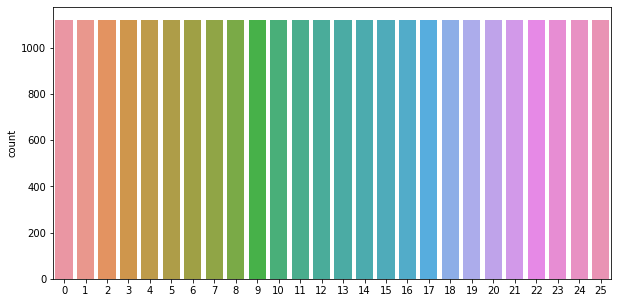

In [6]:
plt.figure(figsize = (10,5))
sns.countplot(y_data)

Total 29120 images of size 28*28 = 784

In [7]:
print(X_data.shape)
print(y_data.shape)

(29120, 784)
(29120,)


Label Binarizer is an SciKit Learn class that accepts Categorical data as input and returns an Numpy array.

In [10]:
lB = LabelBinarizer()
y = lB.fit_transform(y_data)
X_data = X_data / 255
X_data = np.array(X_data)
print(X_data.shape)
X_data = X_data.reshape(-1,28,28,1)
print(X_data.shape)
print(y_data.shape)

(29120, 784)
(29120, 28, 28, 1)
(29120,)


Showing few images:

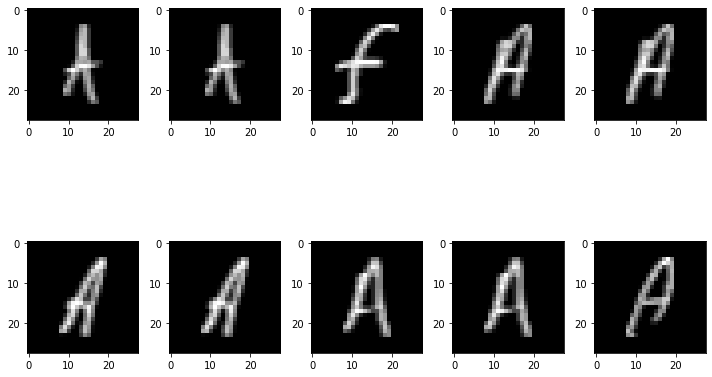

In [11]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10,10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_data[k].reshape(28,28), cmap='gray')
        k += 1
    plt.tight_layout()

Splitting into test and validation sets:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) 
print(X_test.shape)
print(X_valid.shape) 
print(y_train.shape) 
print(y_test.shape)
print(y_valid.shape)

(18636, 28, 28, 1)
(5824, 28, 28, 1)
(4660, 28, 28, 1)
(18636, 26)
(5824, 26)
(4660, 26)


So we have 18636 images in training set, 5824 in testing set and 4660 in validation set.

**Data Augmentation**:
To reduce overfitting of model

In [18]:
dataGen = ImageDataGenerator(rotation_range=10,
                             zoom_range=0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1)
dataGen.fit(X_train)

Reduce learning rate when a metric has stopped improving.

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.5, min_lr=0.00001)

Creating our sequential, convolutional model:

In [23]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 26 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 75)        750       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 75)        300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 50)          0

Training our model in augmented dataset:

In [24]:
history = model.fit(dataGen.flow(X_train,y_train, batch_size = 128) ,epochs = 5 , 
                    validation_data = (X_valid, y_valid) , 
                    callbacks = [learning_rate_reduction])

Epoch 1/5
146/146 [==============================] - 72s 484ms/step - loss: 1.6679 - accuracy: 0.5296 - val_loss: 2.9655 - val_accuracy: 0.0944
Epoch 2/5
146/146 [==============================] - 70s 477ms/step - loss: 0.3273 - accuracy: 0.9019 - val_loss: 2.1946 - val_accuracy: 0.2633
Epoch 3/5
146/146 [==============================] - 74s 510ms/step - loss: 0.2184 - accuracy: 0.9327 - val_loss: 0.7417 - val_accuracy: 0.7691
Epoch 4/5
146/146 [==============================] - 69s 475ms/step - loss: 0.1637 - accuracy: 0.9504 - val_loss: 0.1717 - val_accuracy: 0.9536
Epoch 5/5
146/146 [==============================] - 70s 476ms/step - loss: 0.1438 - accuracy: 0.9583 - val_loss: 0.1081 - val_accuracy: 0.9693


**Statistics during model fitting:**

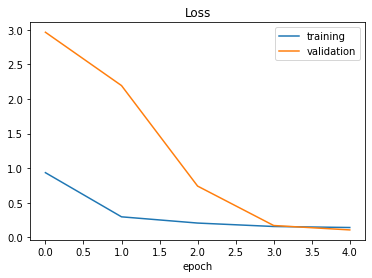

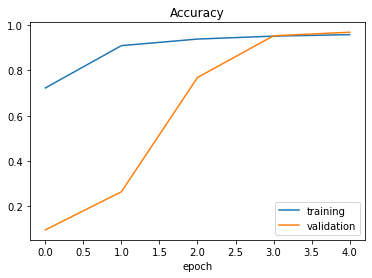

In [25]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()

In [26]:
score = model.evaluate(X_test,y_test,verbose=0)
print('Test Score = ',score[0])
print('Test Accuracy =', score[1])

Test Score =  0.10512766242027283
Test Accuracy = 0.9721840620040894


## Testing our model on images:

In [39]:
predictions =np.argmax(model.predict(X_test), axis=-1)
print("Predicted Values")
print(predictions[:5]) 
print("Actual Labels")
y_test[0:5]

Predicted Values
[ 3  8  1 20 14]
Actual Labels


array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]])

Showing predicted values for 35 images:

Dictionationary for classes:

In [29]:
className = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E',
             5:'F', 6:'G', 7:'H', 8:'I', 9:'J',
             10:'K', 11:'L', 12:'M', 13:'N', 14:'O',
             15:'P', 16:'Q', 17:'R', 18:'S', 19:'T', 
             20:'U', 21:'V', 22:'W', 23:'X', 24:'Y',
             25:'Z'}

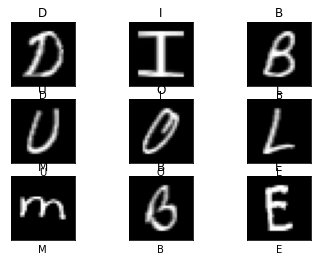

In [34]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_test[i].reshape(28,28), cmap='gray')
    plt.title(className[np.argmax(y_test[i])])
    plt.xlabel(className[predictions[i]])
plt.show()

Links:
* [Dependent and Independent Features: PluralSight](https://www.pluralsight.com/guides/importing-and-splitting-data-into-dependent-and-independent-features-for-ml)
* [kaggle/ggarkoti02](https://www.kaggle.com/ggarkoti02/alphabet-recognizer)
* [kaggle/yairhadad1](https://www.kaggle.com/yairhadad1/cnn-for-handwritten-alphabets)
* [ReduceLROnPlateau](htthttps://keras.io/api/callbacks/reduce_lr_on_plateau/ps://)
* [victorzhou - CNN Blog](https://victorzhou.com/blog/intro-to-cnns-part-1/)
* [cnn-from-scratch - github/vzhou842](https://github.com/vzhou842/cnn-from-scratch)
* [NearMiss](https://analyticsindiamag.com/using-near-miss-algorithm-for-imbalanced-datasets/)